In [1]:
import os
import gzip
import shutil
import tarfile
import imageio
import imagecodecs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch
from packaging import version
import torchxrayvision as xrv
import pandas as pd
from torchvision import transforms
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time

from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch

In [2]:
##### Checking the System #####
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False
    
##### Requesting a GPU ####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

Chosen GPU: 0


In [39]:
os.chdir("/scratch/tmp/")
# !git clone https://github.com/ieee8023/covid-chestxray-dataset
# chest_xray_dataset = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",
#                                  csvpath="covid-chestxray-dataset/metadata.csv")
lab = np.zeros([1,25])
for k in range(535):
    sample = chest_xray_dataset[k]
    plt.imshow(sample["img"][0], cmap="gray");
    lab += sample["lab"]
label = pd.Series(dict(zip(chest_xray_dataset.pathologies,lab)))
label

for k in range(25):
    print(chest_xray_dataset.pathologies[k],":",lab[0,k])
for k in range(25):
    print(chest_xray_dataset.pathologies[k],": {:2.2f}%".format(100*lab[0,k]/535))

Aspergillosis : 1.0
Aspiration : 1.0
Bacterial : 48.0
COVID-19 : 342.0
Chlamydophila : 1.0
Fungal : 23.0
H1N1 : 1.0
Herpes  : 3.0
Influenza : 4.0
Klebsiella : 9.0
Legionella : 9.0
Lipoid : 8.0
MERS-CoV : 8.0
MRSA : 1.0
Mycoplasma : 5.0
No Finding : 15.0
Nocardia : 4.0
Pneumocystis : 22.0
Pneumonia : 509.0
SARS : 16.0
Staphylococcus : 1.0
Streptococcus : 17.0
Tuberculosis : 11.0
Varicella : 5.0
Viral : 378.0
Aspergillosis : 0.19%
Aspiration : 0.19%
Bacterial : 8.97%
COVID-19 : 63.93%
Chlamydophila : 0.19%
Fungal : 4.30%
H1N1 : 0.19%
Herpes  : 0.56%
Influenza : 0.75%
Klebsiella : 1.68%
Legionella : 1.68%
Lipoid : 1.50%
MERS-CoV : 1.50%
MRSA : 0.19%
Mycoplasma : 0.93%
No Finding : 2.80%
Nocardia : 0.75%
Pneumocystis : 4.11%
Pneumonia : 95.14%
SARS : 2.99%
Staphylococcus : 0.19%
Streptococcus : 3.18%
Tuberculosis : 2.06%
Varicella : 0.93%
Viral : 70.65%


In [4]:
##### Preprocess Image #####
## This function is used to crop the largest 1:1 aspect ratio region of a given image.
## This is useful, especially for medical datasets, since many datasets have images
## with different aspect ratios and this is one way to standardize inputs' size.
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [5]:
##### Split a dataset for training, validatation, and testing #####
## This function splits a given dataset into 3 subsets of 60%-20%-20% for train-val-test, respectively.
## This function is used internally in the dataset classes below.
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'val':
        array_to_split = array_to_split[:int(len(array_to_split)*0.5)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.5):int(len(array_to_split)*1)]
    return array_to_split


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1.]


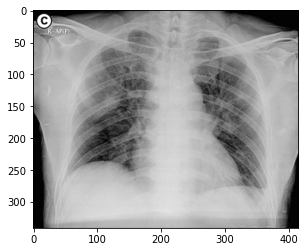

In [6]:
os.chdir("/scratch/tmp/")
pre_set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
         transforms.ToTensor(), 
         transforms.Normalize(mean=[0.5],std=[0.5])])
perm_alt_trans = transforms.Compose([transforms.RandomAffine(degrees = (1,1),translate = (0.025,0.025),
                                                             scale = (0.95,1.05),shear = (3,6))])
perm_alt_trans2 = transforms.Compose([transforms.RandomAffine(degrees = (-1,-1),translate = (0.025,0.025),
                                                             shear = (-6,-3))])


chest_xray_dataset2 = copy.deepcopy(chest_xray_dataset)
sample = chest_xray_dataset2[33]
fig,ax = plt.subplots()
plt.imshow(sample["img"][0], cmap="gray");
print(sample["lab"])

chest_xray_dataset_pre_img = []
chest_xray_dataset_pre_lab = []
chest_xray_pre_alt_img = []
chest_xray_pre_alt_img2 = []
for k in range(len(chest_xray_dataset2)):
    stand_img = pre_set_of_transforms(Image.fromarray(chest_xray_dataset2[k]["img"][0]))
    chest_xray_dataset_pre_img.append(stand_img)
    chest_xray_dataset_pre_lab.append(chest_xray_dataset2[k]["lab"])
    chest_xray_pre_alt_img.append(perm_alt_trans(stand_img))
    chest_xray_pre_alt_img2.append(perm_alt_trans2(stand_img))

chest_data_pre = np.column_stack((chest_xray_dataset_pre_img,chest_xray_dataset_pre_lab))
chest_data_pre_alt = np.column_stack((chest_xray_pre_alt_img,chest_xray_dataset_pre_lab))
chest_data_pre_alt2 = np.column_stack((chest_xray_pre_alt_img2,chest_xray_dataset_pre_lab))

In [7]:
class PneumoDataset24(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train',do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        p_idx = list(range(len(chest_xray_dataset)))
        if split != 'none':
            p_idx = list(get_split(p_idx,split))
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        ex_use = []
        self.img_list = []
        self.target_list = []
        self.do_transform = do_transform
        lab_index = list(range(18))+list(range(19,25)) 
        for idx in p_idx:
            ex_use.append(chest_data_pre[idx,:])
            self.img_list.append(chest_data_pre[idx,0])
            lab_list = np.array(list(chest_data_pre[idx,1:]))
            self.target_list.append(lab_list[lab_index])       
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_image = self.img_list[index]
        image_to_return = curr_image
        if self.do_transform:
            aug_num = random.randrange(1,3,1)
            if aug_num == 1:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,translate = (0.1,0.1))
                ])
            if aug_num == 2:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,scale = (0.9,1.1))
                ])
            if aug_num == 3:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0,translate = (0.1,0.1),scale = (0.9,1.1))
                ])
            if aug_num == 4:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0)
                ])
            image_to_return = augmentation_transforms(image_to_return)
            
        return image_to_return, torch.FloatTensor(self.target_list[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.img_list)

In [8]:
class PneumoDataset24_val(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train',do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        p_idx = list(range(len(chest_xray_dataset)))
        if split != 'none':
            p_idx = list(get_split(p_idx,split))
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        ex_use = []
        self.img_list = []
        self.target_list = []
        self.do_transform = do_transform
        lab_index = list(range(18))+list(range(19,25)) 
        for idx in p_idx:
            ex_use.append(chest_data_pre_alt[idx,:])
            self.img_list.append(chest_data_pre_alt[idx,0])
            lab_list = np.array(list(chest_data_pre_alt[idx,1:]))
            self.target_list.append(lab_list[lab_index])       
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_image = self.img_list[index]
        image_to_return = curr_image
        if self.do_transform:
            aug_num = random.randrange(1,3,1)
            if aug_num == 1:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,translate = (0.1,0.1))
                ])
            if aug_num == 2:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,scale = (0.9,1.1))
                ])
            if aug_num == 3:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0,translate = (0.1,0.1),scale = (0.9,1.1))
                ])
            if aug_num == 4:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0)
                ])
            image_to_return = augmentation_transforms(image_to_return)
            
        return image_to_return, torch.FloatTensor(self.target_list[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.img_list)

In [9]:
class PneumoDataset24_test(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train',do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        p_idx = list(range(len(chest_xray_dataset)))
        if split != 'none':
            p_idx = list(get_split(p_idx,split))
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        ex_use = []
        self.img_list = []
        self.target_list = []
        self.do_transform = do_transform
        lab_index = list(range(18))+list(range(19,25)) 
        for idx in p_idx:
            ex_use.append(chest_data_pre_alt2[idx,:])
            self.img_list.append(chest_data_pre_alt2[idx,0])
            lab_list = np.array(list(chest_data_pre_alt2[idx,1:]))
            self.target_list.append(lab_list[lab_index])       
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_image = self.img_list[index]
        image_to_return = curr_image
        if self.do_transform:
            aug_num = random.randrange(1,3,1)
            if aug_num == 1:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,translate = (0.1,0.1))
                ])
            if aug_num == 2:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,scale = (0.9,1.1))
                ])
            if aug_num == 3:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0,translate = (0.1,0.1),scale = (0.9,1.1))
                ])
            if aug_num == 4:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0)
                ])
            image_to_return = augmentation_transforms(image_to_return)
            
        return image_to_return, torch.FloatTensor(self.target_list[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.img_list)

In [10]:
class PneumoDataset3(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train',do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        p_idx = list(range(len(chest_xray_dataset)))
        if split != 'none':
            p_idx = list(get_split(p_idx,split))
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        ex_use = []
        self.img_list = []
        self.target_list = []
        self.do_transform = do_transform
        lab_index = [2,5,24]
        for idx in p_idx:
            ex_use.append(chest_data_pre[idx,:])
            self.img_list.append(chest_data_pre[idx,0])
            lab_list = np.array(list(chest_data_pre[idx,1:]))
            self.target_list.append(lab_list[lab_index])       
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_image = self.img_list[index]
        image_to_return = curr_image
        if self.do_transform:
            aug_num = random.randrange(1,3,1)
            if aug_num == 1:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,translate = (0.1,0.1))
                ])
            if aug_num == 2:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,scale = (0.9,1.1))
                ])
            if aug_num == 3:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0,translate = (0.1,0.1),scale = (0.9,1.1))
                ])
            if aug_num == 4:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0)
                ])
            image_to_return = augmentation_transforms(image_to_return)
            
        return image_to_return, torch.FloatTensor(self.target_list[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.img_list)

In [11]:
class PneumoDataset3_val(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train',do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        p_idx = list(range(len(chest_xray_dataset)))
        if split != 'none':
            p_idx = list(get_split(p_idx,split))
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        ex_use = []
        self.img_list = []
        self.target_list = []
        self.do_transform = do_transform
        lab_index = [2,5,24]
        for idx in p_idx:
            ex_use.append(chest_data_pre_alt[idx,:])
            self.img_list.append(chest_data_pre_alt[idx,0])
            lab_list = np.array(list(chest_data_pre_alt[idx,1:]))
            self.target_list.append(lab_list[lab_index])       
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_image = self.img_list[index]
        image_to_return = curr_image
        if self.do_transform:
            aug_num = random.randrange(1,3,1)
            if aug_num == 1:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,translate = (0.1,0.1))
                ])
            if aug_num == 2:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 2,scale = (0.9,1.1))
                ])
            if aug_num == 3:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0,translate = (0.1,0.1),scale = (0.9,1.1))
                ])
            if aug_num == 4:
                augmentation_transforms = transforms.Compose([
                    transforms.RandomAffine(degrees = 0)
                ])
            image_to_return = augmentation_transforms(image_to_return)
            
        return image_to_return, torch.FloatTensor(self.target_list[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.img_list)

In [51]:
train_dataset = PneumoDataset24(chest_data_pre,split = 'none',do_transform = True)
val_dataset = PneumoDataset24_val(chest_data_pre_alt,split = 'none',do_transform = False)
test_dataset = PneumoDataset24_test(chest_data_pre_alt2, split = 'none',do_transform = False)

train_loader24_pre = torch.utils.data.DataLoader(train_dataset,batch_size = 8, shuffle = True, num_workers = 0)
val_loader24_pre = torch.utils.data.DataLoader(val_dataset,batch_size = 8, shuffle = True, num_workers = 0)
test_loader24 = torch.utils.data.DataLoader(test_dataset,batch_size = 8, shuffle = True, num_workers = 0)

Text(0.5, 1.0, 'From Test Loader')

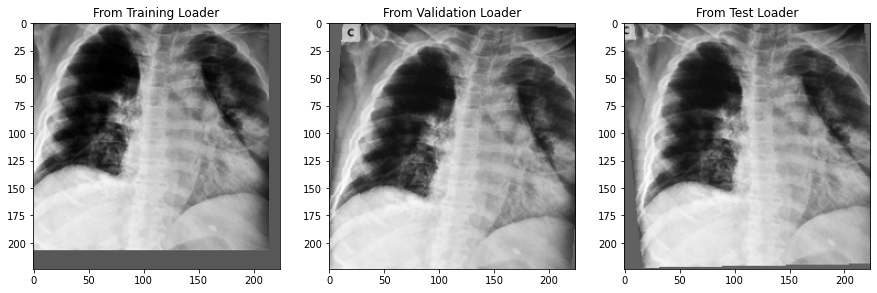

In [52]:
idx = 2
train_img,train_lab = train_loader24_pre.dataset[idx]
val_img,val_lab = val_loader24_pre.dataset[idx]
test_img,test_lab = test_loader24.dataset[idx]

fig,ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(train_img[0],cmap="gray")
ax[0].set_title("From Training Loader")
ax[1].imshow(val_img[0],cmap="gray")
ax[1].set_title("From Validation Loader")
ax[2].imshow(test_img[0],cmap="gray")
ax[2].set_title("From Test Loader")

In [13]:
##### Compute accuracy for COVID dataset #####
def get_accuracy24(model, data_loader):
    model.eval()
    with torch.no_grad():
        acc_list = []
        
        for image, target in data_loader:
            image = image.cuda(); 
            target = target.cuda()
            probs = model(image)
            preds = torch.sigmoid(probs)

            pred_prob = (preds > 0.5) * torch.from_numpy(np.ones([preds.size()[0],24])).cuda()
            size_pred = pred_prob.size()
            pred_prob = pred_prob.cpu().detach().numpy()
            target = target.cpu().detach().numpy()

            correct = 0
            total_img = 0
            for i in range(np.shape(pred_prob)[0]):
                if(np.all(pred_prob[i,:] == target[i,:])):
                    correct = correct+1
                total_img = total_img+1
            acc_list.append(correct/total_img)
        acc = np.mean(acc_list)
    return acc

In [14]:
##### Compute accuracy for COVID dataset #####
def get_accuracy3(model, data_loader):
    model.eval()
    with torch.no_grad():
        acc_list = []
        
        for image, target in data_loader:
            image = image.cuda(); 
            target = target.cuda()
            probs = model(image)
            preds = torch.sigmoid(probs)

            pred_prob = (preds > 0.5) * torch.from_numpy(np.ones([preds.size()[0],3])).cuda()
            size_pred = pred_prob.size()
            pred_prob = pred_prob.cpu().detach().numpy()
            target = target.cpu().detach().numpy()

            correct = 0
            total_img = 0
            for i in range(np.shape(pred_prob)[0]):
                if(np.all(pred_prob[i,:] == target[i,:])):
                    correct = correct+1
                total_img = total_img+1
            acc_list.append(correct/total_img)
        acc = np.mean(acc_list)
    return acc

In [15]:
##### Compute the number parameters (weights) #####
## This function computes the number of learnable parameters in a Pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
def training_stage(epoch, optimizer, loss, model, train_loader, val_loader):
    model.train()
    loss_values = []
    for batch_idx, (image, label) in enumerate(train_loader):
        ### Your code starts here ###
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            image = image.cuda()
            label = label.cuda()
            outputs = model(image)
            loss_value = loss(outputs,label)
            loss_value.backward()
            optimizer.step()
        ### Your code ends here ###
        loss_values.append(loss_value.item())
    return np.mean(loss_values)

In [17]:

MLoss = torch.nn.MultiLabelSoftMarginLoss()


In [18]:
model_24class = torch.nn.Sequential(
        torch.nn.ZeroPad2d(2),
        torch.nn.Conv2d(1,16,5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(16,64,3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(64,128,3),
        torch.nn.ReLU(),
        torch.nn.AdaptiveAvgPool2d(output_size = (3,3)),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = 1152, out_features = 256),
        torch.nn.Dropout(p=0.33),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 256, out_features = 24)
)
model_24class = model_24class.cuda()

Number of Parameters: 384888


 Learning Rate =  0.01 



Initial accuracy - training and validation: 0.0 0.0 


Train Epoch: 0 	Loss: 2.17844
Train Acc: 0.63913 
Val Acc: 0.63859

Epoch time: 3.613394260406494 


Train Epoch: 1 	Loss: 0.13451
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 3.8753864765167236 


Train Epoch: 2 	Loss: 0.13562
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 3.864515542984009 


Train Epoch: 3 	Loss: 0.13484
Train Acc: 0.63913 
Val Acc: 0.63966

Epoch time: 3.8888466358184814 


Train Epoch: 4 	Loss: 0.13326
Train Acc: 0.63993 
Val Acc: 0.63913

Epoch time: 3.8372552394866943 


Train Epoch: 5 	Loss: 0.13266
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.7718677520751953 


Train Epoch: 6 	Loss: 0.13164
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.559020757675171 


Train Epoch: 7 	Loss: 0.13196
Train Acc: 0.63966 
Val Acc: 0.63833

Epoch time: 3.5896804332733154 


Train Epoch: 8 	Loss: 0.13210
Train Acc: 0.63913 
Val Acc: 0.63939

Epoch 

Train Epoch: 79 	Loss: 0.12754
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch time: 3.6156060695648193 


Train Epoch: 80 	Loss: 0.12619
Train Acc: 0.63753 
Val Acc: 0.63913

Epoch time: 3.5785861015319824 


Train Epoch: 81 	Loss: 0.12715
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.5747036933898926 


Train Epoch: 82 	Loss: 0.12557
Train Acc: 0.63939 
Val Acc: 0.63886

Epoch time: 3.5917248725891113 


Train Epoch: 83 	Loss: 0.12590
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.5983495712280273 


Train Epoch: 84 	Loss: 0.12693
Train Acc: 0.63513 
Val Acc: 0.63939

Epoch time: 3.5748367309570312 


Train Epoch: 85 	Loss: 0.12737
Train Acc: 0.63539 
Val Acc: 0.63913

Epoch time: 3.59173846244812 


Train Epoch: 86 	Loss: 0.12599
Train Acc: 0.63486 
Val Acc: 0.63939

Epoch time: 3.5916237831115723 


Train Epoch: 87 	Loss: 0.12687
Train Acc: 0.63726 
Val Acc: 0.63939

Epoch time: 3.5922510623931885 


Train Epoch: 88 	Loss: 0.12693
Train Acc: 0.63939 
Val Acc: 0.63966

Epoch 

Train Epoch: 59 	Loss: 0.03834
Train Acc: 0.82063 
Val Acc: 0.83929

Epoch time: 3.8692407608032227 


Train Epoch: 60 	Loss: 0.03846
Train Acc: 0.83875 
Val Acc: 0.84275

Epoch time: 3.7144265174865723 


Train Epoch: 61 	Loss: 0.03763
Train Acc: 0.82623 
Val Acc: 0.83929

Epoch time: 3.6072773933410645 


Train Epoch: 62 	Loss: 0.03544
Train Acc: 0.83715 
Val Acc: 0.84142

Epoch time: 3.9246881008148193 


Train Epoch: 63 	Loss: 0.03877
Train Acc: 0.83929 
Val Acc: 0.84488

Epoch time: 3.6045615673065186 


Train Epoch: 64 	Loss: 0.03733
Train Acc: 0.85794 
Val Acc: 0.84462

Epoch time: 3.6014835834503174 


Train Epoch: 65 	Loss: 0.03686
Train Acc: 0.83582 
Val Acc: 0.84648

Epoch time: 3.6184306144714355 


Train Epoch: 66 	Loss: 0.03493
Train Acc: 0.85794 
Val Acc: 0.84088

Epoch time: 3.6255507469177246 


Train Epoch: 67 	Loss: 0.03782
Train Acc: 0.85421 
Val Acc: 0.84462

Epoch time: 3.6055431365966797 


Train Epoch: 68 	Loss: 0.03536
Train Acc: 0.84275 
Val Acc: 0.84648

Epoc

Train Epoch: 39 	Loss: 0.08752
Train Acc: 0.64472 
Val Acc: 0.65832

Epoch time: 3.6462762355804443 


Train Epoch: 40 	Loss: 0.08562
Train Acc: 0.65991 
Val Acc: 0.66551

Epoch time: 3.572220802307129 


Train Epoch: 41 	Loss: 0.08530
Train Acc: 0.67511 
Val Acc: 0.67111

Epoch time: 3.5657031536102295 


Train Epoch: 42 	Loss: 0.08088
Train Acc: 0.66151 
Val Acc: 0.66391

Epoch time: 3.586669445037842 


Train Epoch: 43 	Loss: 0.08620
Train Acc: 0.64499 
Val Acc: 0.66684

Epoch time: 3.5906150341033936 


Train Epoch: 44 	Loss: 0.08740
Train Acc: 0.67111 
Val Acc: 0.66525

Epoch time: 3.547605276107788 


Train Epoch: 45 	Loss: 0.08793
Train Acc: 0.63699 
Val Acc: 0.66924

Epoch time: 3.755918502807617 


Train Epoch: 46 	Loss: 0.08298
Train Acc: 0.64312 
Val Acc: 0.66125

Epoch time: 3.871168375015259 


Train Epoch: 47 	Loss: 0.08212
Train Acc: 0.67537 
Val Acc: 0.67857

Epoch time: 3.8888742923736572 


Train Epoch: 48 	Loss: 0.08622
Train Acc: 0.65059 
Val Acc: 0.67724

Epoch tim

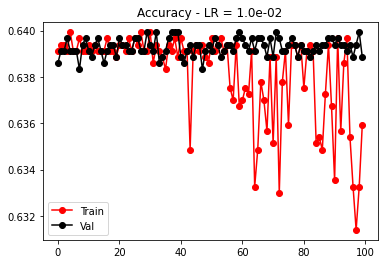

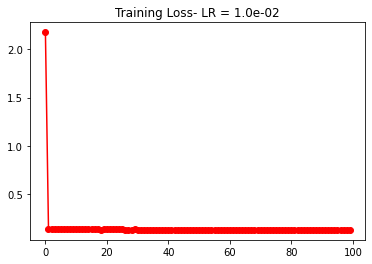

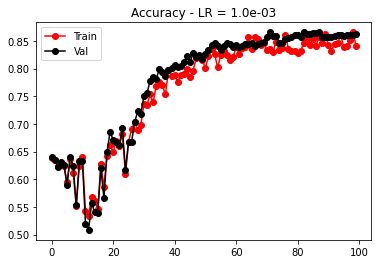

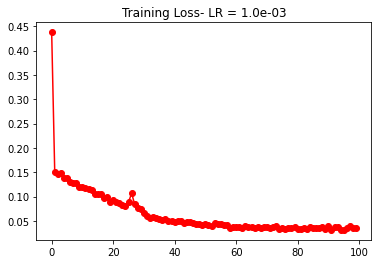

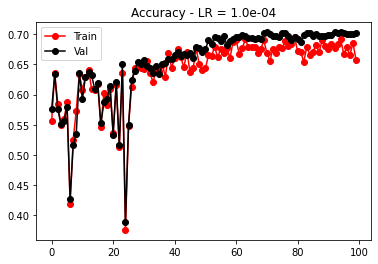

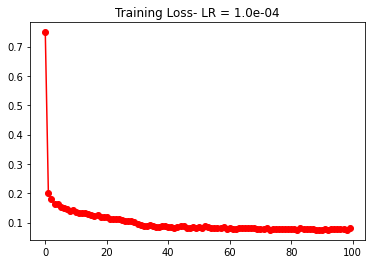

In [19]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-2,1e-3,1e-4] 
print("Number of Parameters:",count_number_parameters(model_24class))
current_best_score = 0.6
for rate in learning_rates: 
    for layer in model_24class.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_24class.parameters(), lr=rate)
    n_epochs = 100

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy24(model_24class,train_loader24_pre)
    start_acc_val_avg = get_accuracy24(model_24class,val_loader24_pre)
    accT = []
    accAVG = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val_avg,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_24class, train_loader24_pre,val_loader24_pre)
        ## Evaluate the current model
        m_acc_train = get_accuracy24(model_24class,train_loader24_pre)
        m_acc_val_avg = get_accuracy24(model_24class,val_loader24_pre)
        current_score = m_acc_val_avg
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_24class = copy.deepcopy(model_24class)
            torch.save(best_model_24class,'./best_model_project_24class_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val_avg))
        print("\nEpoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accAVG.append(m_acc_val_avg)
    plt.figure()
    plt.plot(accT,'ro-',accAVG,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [20]:
# extending the layers so can get rid of adaptive average pooling without having massive parameter
model_24class_ext = torch.nn.Sequential(
        torch.nn.ZeroPad2d(2),
        torch.nn.Conv2d(1,16,5,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(16,64,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(64,96,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(96,128,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(128,192,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = 7*7*192, out_features = 144),
        torch.nn.Dropout(p=0.33),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 144, out_features = 24)
)
model_24class_ext = model_24class_ext.cuda()
print("Number of Parameters:",count_number_parameters(model_24class_ext))

Number of Parameters: 1755560


Number of Parameters: 1755560


 Learning Rate =  0.01 



Initial accuracy - training and validation: 0.0 0.0 


Train Epoch: 0 	Loss: 46.23065
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 4.012791156768799 


Train Epoch: 1 	Loss: 0.13693
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.743659496307373 


Train Epoch: 2 	Loss: 0.13519
Train Acc: 0.63939 
Val Acc: 0.63886

Epoch time: 3.8467843532562256 


Train Epoch: 3 	Loss: 0.13345
Train Acc: 0.63886 
Val Acc: 0.63886

Epoch time: 3.636380910873413 


Train Epoch: 4 	Loss: 0.13640
Train Acc: 0.63966 
Val Acc: 0.63913

Epoch time: 3.8863258361816406 


Train Epoch: 5 	Loss: 0.13311
Train Acc: 0.63913 
Val Acc: 0.63886

Epoch time: 3.7227797508239746 


Train Epoch: 6 	Loss: 0.13375
Train Acc: 0.63859 
Val Acc: 0.63913

Epoch time: 3.592574119567871 


Train Epoch: 7 	Loss: 0.13319
Train Acc: 0.63859 
Val Acc: 0.63913

Epoch time: 3.597088098526001 


Train Epoch: 8 	Loss: 0.13225
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch 

Train Epoch: 80 	Loss: 0.12776
Train Acc: 0.63833 
Val Acc: 0.63966

Epoch time: 3.944326877593994 


Train Epoch: 81 	Loss: 0.12784
Train Acc: 0.63886 
Val Acc: 0.63939

Epoch time: 3.948869466781616 


Train Epoch: 82 	Loss: 0.12829
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch time: 3.946577310562134 


Train Epoch: 83 	Loss: 0.12814
Train Acc: 0.63993 
Val Acc: 0.63939

Epoch time: 3.920853853225708 


Train Epoch: 84 	Loss: 0.12754
Train Acc: 0.63966 
Val Acc: 0.63886

Epoch time: 3.9394266605377197 


Train Epoch: 85 	Loss: 0.12723
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch time: 3.937715530395508 


Train Epoch: 86 	Loss: 0.12812
Train Acc: 0.63886 
Val Acc: 0.63886

Epoch time: 3.9278016090393066 


Train Epoch: 87 	Loss: 0.12809
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 3.957879066467285 


Train Epoch: 88 	Loss: 0.12857
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 3.9318151473999023 


Train Epoch: 89 	Loss: 0.12910
Train Acc: 0.63913 
Val Acc: 0.63993

Epoch time

Train Epoch: 60 	Loss: 0.04892
Train Acc: 0.79611 
Val Acc: 0.81663

Epoch time: 3.7628142833709717 


Train Epoch: 61 	Loss: 0.05004
Train Acc: 0.77985 
Val Acc: 0.81103

Epoch time: 3.9061105251312256 


Train Epoch: 62 	Loss: 0.04859
Train Acc: 0.81903 
Val Acc: 0.81663

Epoch time: 3.6360316276550293 


Train Epoch: 63 	Loss: 0.04880
Train Acc: 0.78305 
Val Acc: 0.80917

Epoch time: 3.631417751312256 


Train Epoch: 64 	Loss: 0.05009
Train Acc: 0.77932 
Val Acc: 0.80757

Epoch time: 3.617525577545166 


Train Epoch: 65 	Loss: 0.04805
Train Acc: 0.81690 
Val Acc: 0.81290

Epoch time: 3.910763740539551 


Train Epoch: 66 	Loss: 0.04532
Train Acc: 0.80171 
Val Acc: 0.81263

Epoch time: 3.9069721698760986 


Train Epoch: 67 	Loss: 0.04678
Train Acc: 0.80171 
Val Acc: 0.81663

Epoch time: 3.9406309127807617 


Train Epoch: 68 	Loss: 0.04984
Train Acc: 0.80410 
Val Acc: 0.82090

Epoch time: 3.6991031169891357 


Train Epoch: 69 	Loss: 0.05286
Train Acc: 0.80144 
Val Acc: 0.81530

Epoch t

Train Epoch: 40 	Loss: 0.04640
Train Acc: 0.82036 
Val Acc: 0.85821

Epoch time: 3.865609645843506 


Train Epoch: 41 	Loss: 0.04560
Train Acc: 0.83182 
Val Acc: 0.85608

Epoch time: 3.8880107402801514 


Train Epoch: 42 	Loss: 0.04774
Train Acc: 0.82809 
Val Acc: 0.84808

Epoch time: 3.920696258544922 


Train Epoch: 43 	Loss: 0.04479
Train Acc: 0.83582 
Val Acc: 0.85821

Epoch time: 3.7442896366119385 


Train Epoch: 44 	Loss: 0.04500
Train Acc: 0.82623 
Val Acc: 0.85981

Epoch time: 3.7065300941467285 


Train Epoch: 45 	Loss: 0.04167
Train Acc: 0.83156 
Val Acc: 0.85448

Epoch time: 3.935530424118042 


Train Epoch: 46 	Loss: 0.04110
Train Acc: 0.83209 
Val Acc: 0.86007

Epoch time: 3.830031633377075 


Train Epoch: 47 	Loss: 0.04222
Train Acc: 0.81716 
Val Acc: 0.85954

Epoch time: 3.604724168777466 


Train Epoch: 48 	Loss: 0.04544
Train Acc: 0.84648 
Val Acc: 0.87687

Epoch time: 4.084035158157349 


Train Epoch: 49 	Loss: 0.04150
Train Acc: 0.83369 
Val Acc: 0.86754

Epoch time

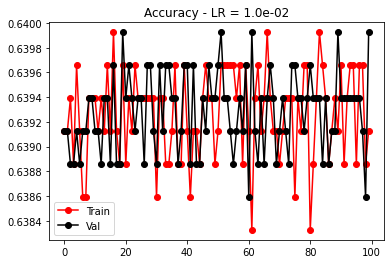

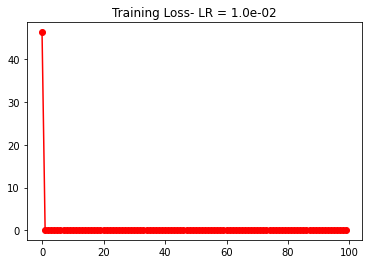

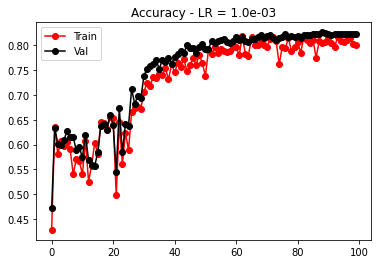

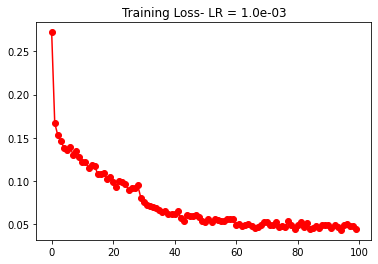

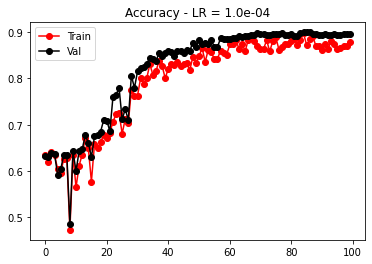

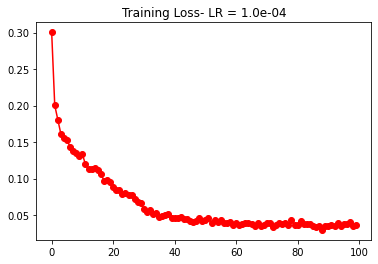

In [21]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-2,1e-3,1e-4] 
print("Number of Parameters:",count_number_parameters(model_24class_ext))
current_best_score = 0.6
for rate in learning_rates: 
    for layer in model_24class_ext.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_24class_ext.parameters(), lr=rate)
    n_epochs = 100

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy24(model_24class_ext,train_loader24_pre)
    start_acc_val = get_accuracy24(model_24class_ext,val_loader24_pre)
    accT = []
    accVal = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_24class_ext, train_loader24_pre, 
                                    val_loader24_pre)
        ## Evaluate the current model
        m_acc_train = get_accuracy24(model_24class_ext,train_loader24_pre)
        m_acc_val = get_accuracy24(model_24class_ext,val_loader24_pre)
        current_score = m_acc_val
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_24class_ext = copy.deepcopy(model_24class_ext)
            torch.save(best_model_24class_ext,'./best_model_project_24class_ext_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val))
        print("\nEpoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accVal.append(m_acc_val)
    plt.figure()
    plt.plot(accT,'ro-',accVal,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [60]:
# Darknet 19 has been shown to perform well at differentiating Covid-19 from other infections so perhaps one 
# inspired by this network will do well at classifying a variety
class DNI_24class(torch.nn.Module):
    def __init__(self):
        super(DNI_24class,self).__init__()
        self.ConvLayers = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride = 2), 
        torch.nn.Conv2d(32,64,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride = 2), 
        torch.nn.Conv2d(64,128,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(128,64,1,1),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(64,128,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride = 2), 
        torch.nn.Conv2d(128,256,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(256,128,1,1),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(128,256,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(256,512,3,1,1),
        torch.nn.ReLU(True),
        torch.nn.Conv2d(512,24,1,1),
        torch.nn.ReLU(True),
        )
    def forward(self,x):
        x = self.ConvLayers(x)
        x = torch.mean(x,[2,3])
        return x

model_24classDNI = DNI_24class().cuda()
print("Number of Parameters:",count_number_parameters(model_24classDNI))

Number of Parameters: 1990488


Number of Parameters: 1990488


 Learning Rate =  0.01 



Initial accuracy - training and validation: 0.0 0.0 


Train Epoch: 0 	Loss: 0.69363
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.743567943572998 


Train Epoch: 1 	Loss: 0.69315
Train Acc: 0.09568 
Val Acc: 0.09542

Epoch time: 5.745457649230957 


Train Epoch: 2 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.71619725227356 


Train Epoch: 3 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.698068380355835 


Train Epoch: 4 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.952255010604858 


Train Epoch: 5 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.7745208740234375 


Train Epoch: 6 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.668715476989746 


Train Epoch: 7 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.635705471038818 


Train Epoch: 8 	Loss: 0.69315
Train Acc: 0.09595 
Val Acc: 0.09542

Epoch time

Train Epoch: 80 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.630171060562134 


Train Epoch: 81 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.869153022766113 


Train Epoch: 82 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09568

Epoch time: 5.916532754898071 


Train Epoch: 83 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.924256324768066 


Train Epoch: 84 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.939381122589111 


Train Epoch: 85 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.939907073974609 


Train Epoch: 86 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.931018352508545 


Train Epoch: 87 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.9693076610565186 


Train Epoch: 88 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.749547719955444 


Train Epoch: 89 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 

Train Epoch: 60 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.933468818664551 


Train Epoch: 61 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.935666799545288 


Train Epoch: 62 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.929008722305298 


Train Epoch: 63 	Loss: 0.69315
Train Acc: 0.09568 
Val Acc: 0.09542

Epoch time: 5.922560691833496 


Train Epoch: 64 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09568

Epoch time: 5.9218268394470215 


Train Epoch: 65 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.926785469055176 


Train Epoch: 66 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.93906831741333 


Train Epoch: 67 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09568

Epoch time: 5.927517414093018 


Train Epoch: 68 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.921670436859131 


Train Epoch: 69 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5

Train Epoch: 40 	Loss: 0.69315
Train Acc: 0.09568 
Val Acc: 0.09515

Epoch time: 5.646552562713623 


Train Epoch: 41 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09568

Epoch time: 5.674388647079468 


Train Epoch: 42 	Loss: 0.69315
Train Acc: 0.09568 
Val Acc: 0.09568

Epoch time: 5.710358381271362 


Train Epoch: 43 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.638151407241821 


Train Epoch: 44 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.658065557479858 


Train Epoch: 45 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09568

Epoch time: 5.632028341293335 


Train Epoch: 46 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.722411632537842 


Train Epoch: 47 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.775873422622681 


Train Epoch: 48 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.663002014160156 


Train Epoch: 49 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5

Train Epoch: 20 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09515

Epoch time: 5.635542392730713 


Train Epoch: 21 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09542

Epoch time: 5.660424709320068 


Train Epoch: 22 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.652447700500488 


Train Epoch: 23 	Loss: 0.69315
Train Acc: 0.09595 
Val Acc: 0.09515

Epoch time: 5.666690826416016 


Train Epoch: 24 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 5.699182987213135 


Train Epoch: 25 	Loss: 0.69315
Train Acc: 0.09542 
Val Acc: 0.09542

Epoch time: 5.925583839416504 


Train Epoch: 26 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09568

Epoch time: 5.920094728469849 


Train Epoch: 27 	Loss: 0.69315
Train Acc: 0.09568 
Val Acc: 0.09542

Epoch time: 5.9260170459747314 


Train Epoch: 28 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09595

Epoch time: 5.930600643157959 


Train Epoch: 29 	Loss: 0.69315
Train Acc: 0.09515 
Val Acc: 0.09515

Epoch time: 

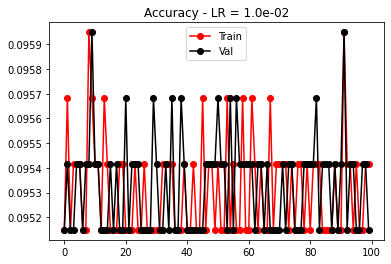

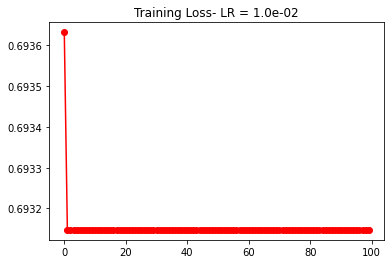

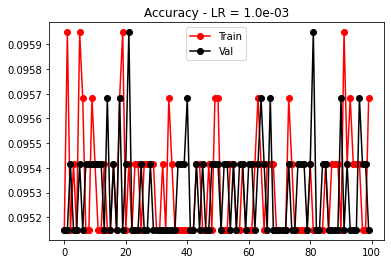

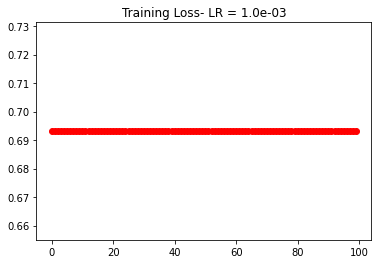

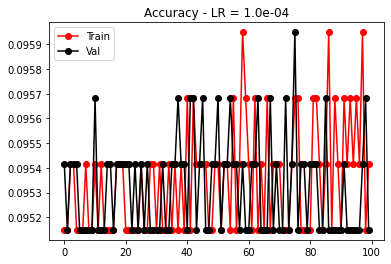

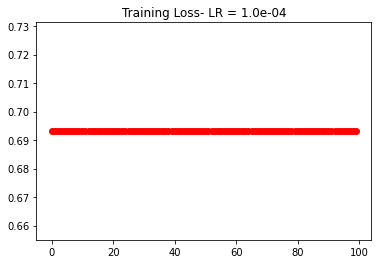

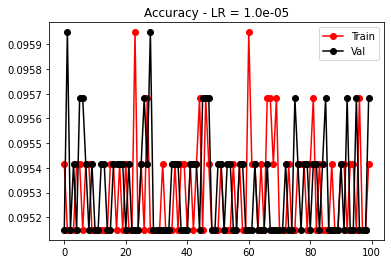

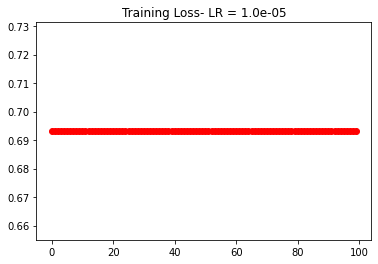

In [25]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-2,1e-3,1e-4,1e-5] 
print("Number of Parameters:",count_number_parameters(model_24classDNI))
current_best_score = 1e-9
for rate in learning_rates: 
    for layer in model_24classDNI.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_24classDNI.parameters(), lr=rate)
    n_epochs = 100

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy24(model_24classDNI,train_loader24_pre)
    start_acc_val = get_accuracy24(model_24classDNI,val_loader24_pre)
    accT = []
    accVal = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_24classDNI, train_loader24_pre, 
                                    val_loader24_pre)
        ## Evaluate the current model
        m_acc_train = get_accuracy24(model_24classDNI,train_loader24_pre)
        m_acc_val = get_accuracy24(model_24classDNI,val_loader24_pre)
        current_score = m_acc_val
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_24classDNI = copy.deepcopy(model_24classDNI)
            torch.save(best_model_24classDNI,'./best_model_project_24classDNI_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val))
        print("\nEpoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accVal.append(m_acc_val)
    plt.figure()
    plt.plot(accT,'ro-',accVal,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [61]:
#5 conv layer with residual connection at 1-3 and 2-5
class ResInsp24class(torch.nn.Module):
    def __init__(self):
        super(ResInsp24class,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,16,5,1,2)
        self.relu = torch.nn.ReLU(True)
        self.maxPool = torch.nn.MaxPool2d(2,stride = 2)
        self.conv2 = torch.nn.Conv2d(16,64,3,1,1)
        self.conv3 = torch.nn.Conv2d(64,96,3,1,1)
        self.conv4 = torch.nn.Conv2d(96,128,3,1,1)
        self.conv5 = torch.nn.Conv2d(128,192,3,1,1)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(7*7*192,144)
        self.fc2 = torch.nn.Linear(144,24)
        self.drop = torch.nn.Dropout(p=0.33)
        self.down1 = torch.nn.Conv2d(1,64,1,4)
        self.down2 = torch.nn.Conv2d(16,96,1,4)
        self.down3 = torch.nn.Conv2d(64,128,1,4)
        
    def forward(self,x):
        res1 = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxPool(out)
        
        res2 = out
        out = self.conv2(out)
        out = self.maxPool(out)
        res3 = out
        out += self.down1(res1)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.maxPool(out)
        out += self.down2(res2)
        out = self.relu(out)
        
        out = self.conv4(out)
        out = self.maxPool(out)
        out += self.down3(res3)
        out = self.relu(out)
        
        out = self.conv5(out)
        out = self.relu(out)
        out = self.maxPool(out)
        
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out
        

model_24class_Res = ResInsp24class().cuda()
print("Number of Parameters:",count_number_parameters(model_24class_Res))

Number of Parameters: 1765640


Number of Parameters: 1765640


 Learning Rate =  0.001 



Initial accuracy - training and validation: 0.0 0.0 


Train Epoch: 0 	Loss: 0.98317
Train Acc: 0.58902 
Val Acc: 0.60394

Epoch time: 4.149708032608032 


Train Epoch: 1 	Loss: 0.17115
Train Acc: 0.63699 
Val Acc: 0.63966

Epoch time: 4.319357633590698 


Train Epoch: 2 	Loss: 0.15675
Train Acc: 0.63033 
Val Acc: 0.63939

Epoch time: 4.186532497406006 


Train Epoch: 3 	Loss: 0.14660
Train Acc: 0.47841 
Val Acc: 0.57196

Epoch time: 3.972482681274414 


Train Epoch: 4 	Loss: 0.14859
Train Acc: 0.61514 
Val Acc: 0.63539

Epoch time: 4.044623374938965 


Train Epoch: 5 	Loss: 0.13890
Train Acc: 0.60261 
Val Acc: 0.62233

Epoch time: 3.9465348720550537 


Train Epoch: 6 	Loss: 0.13912
Train Acc: 0.62420 
Val Acc: 0.63380

Epoch time: 3.9819352626800537 


Train Epoch: 7 	Loss: 0.12993
Train Acc: 0.61087 
Val Acc: 0.61461

Epoch time: 4.020272970199585 


Train Epoch: 8 	Loss: 0.13786
Train Acc: 0.56796 
Val Acc: 0.57409

Epoch t

Train Epoch: 80 	Loss: 0.09240
Train Acc: 0.59595 
Val Acc: 0.64339

Epoch time: 3.7470622062683105 


Train Epoch: 81 	Loss: 0.09581
Train Acc: 0.61327 
Val Acc: 0.64099

Epoch time: 3.746253252029419 


Train Epoch: 82 	Loss: 0.09312
Train Acc: 0.61541 
Val Acc: 0.65032

Epoch time: 3.9002346992492676 


Train Epoch: 83 	Loss: 0.09291
Train Acc: 0.62607 
Val Acc: 0.64845

Epoch time: 4.030749797821045 


Train Epoch: 84 	Loss: 0.09086
Train Acc: 0.63380 
Val Acc: 0.64659

Epoch time: 3.928452491760254 


Train Epoch: 85 	Loss: 0.09068
Train Acc: 0.63326 
Val Acc: 0.65272

Epoch time: 3.8754377365112305 


Train Epoch: 86 	Loss: 0.08891
Train Acc: 0.61834 
Val Acc: 0.64472

Epoch time: 4.11506199836731 


Train Epoch: 87 	Loss: 0.09144
Train Acc: 0.63593 
Val Acc: 0.64632

Epoch time: 4.031723737716675 


Train Epoch: 88 	Loss: 0.09047
Train Acc: 0.62393 
Val Acc: 0.65032

Epoch time: 4.010923862457275 


Train Epoch: 89 	Loss: 0.08844
Train Acc: 0.62393 
Val Acc: 0.64286

Epoch time:

Train Epoch: 30 	Loss: 0.09210
Train Acc: 0.67324 
Val Acc: 0.70656

Epoch time: 3.802931547164917 


Train Epoch: 31 	Loss: 0.08406
Train Acc: 0.69003 
Val Acc: 0.71269

Epoch time: 3.8398256301879883 


Train Epoch: 32 	Loss: 0.08010
Train Acc: 0.69190 
Val Acc: 0.71962

Epoch time: 3.8050954341888428 


Train Epoch: 33 	Loss: 0.08156
Train Acc: 0.68977 
Val Acc: 0.71562

Epoch time: 3.759293556213379 


Train Epoch: 34 	Loss: 0.08243
Train Acc: 0.70309 
Val Acc: 0.72308

Epoch time: 3.9606165885925293 


Train Epoch: 35 	Loss: 0.08098
Train Acc: 0.68763 
Val Acc: 0.72361

Epoch time: 4.0403196811676025 


Train Epoch: 36 	Loss: 0.07991
Train Acc: 0.69696 
Val Acc: 0.71962

Epoch time: 3.73978328704834 


Train Epoch: 37 	Loss: 0.07653
Train Acc: 0.72708 
Val Acc: 0.71215

Epoch time: 3.746807813644409 


Train Epoch: 38 	Loss: 0.08081
Train Acc: 0.70656 
Val Acc: 0.72548

Epoch time: 3.8288373947143555 


Train Epoch: 39 	Loss: 0.07704
Train Acc: 0.70442 
Val Acc: 0.71002

Epoch tim

Train Epoch: 110 	Loss: 0.05637
Train Acc: 0.77745 
Val Acc: 0.76279

Epoch time: 3.75274920463562 


Train Epoch: 111 	Loss: 0.06444
Train Acc: 0.75533 
Val Acc: 0.76199

Epoch time: 3.75734281539917 


Train Epoch: 112 	Loss: 0.06429
Train Acc: 0.78545 
Val Acc: 0.76039

Epoch time: 3.752253770828247 


Train Epoch: 113 	Loss: 0.05957
Train Acc: 0.76439 
Val Acc: 0.76066

Epoch time: 3.729741096496582 


Train Epoch: 114 	Loss: 0.06717
Train Acc: 0.76199 
Val Acc: 0.76279

Epoch time: 3.7281692028045654 


Train Epoch: 115 	Loss: 0.06674
Train Acc: 0.76093 
Val Acc: 0.76652

Epoch time: 3.748284339904785 


Train Epoch: 116 	Loss: 0.06575
Train Acc: 0.76306 
Val Acc: 0.76226

Epoch time: 3.7903313636779785 


Train Epoch: 117 	Loss: 0.05940
Train Acc: 0.75160 
Val Acc: 0.76439

Epoch time: 3.8170664310455322 


Train Epoch: 118 	Loss: 0.06400
Train Acc: 0.78891 
Val Acc: 0.76493

Epoch time: 3.755399227142334 


Train Epoch: 119 	Loss: 0.05850
Train Acc: 0.76306 
Val Acc: 0.76466

Ep

Train Epoch: 60 	Loss: 0.20178
Train Acc: 0.50880 
Val Acc: 0.51919

Epoch time: 3.7399189472198486 


Train Epoch: 61 	Loss: 0.19905
Train Acc: 0.54584 
Val Acc: 0.52026

Epoch time: 3.7524633407592773 


Train Epoch: 62 	Loss: 0.19741
Train Acc: 0.51013 
Val Acc: 0.52505

Epoch time: 3.7542977333068848 


Train Epoch: 63 	Loss: 0.20290
Train Acc: 0.52719 
Val Acc: 0.51786

Epoch time: 3.724303722381592 


Train Epoch: 64 	Loss: 0.19453
Train Acc: 0.52905 
Val Acc: 0.52106

Epoch time: 3.7260401248931885 


Train Epoch: 65 	Loss: 0.20307
Train Acc: 0.49654 
Val Acc: 0.51359

Epoch time: 3.7267959117889404 


Train Epoch: 66 	Loss: 0.20255
Train Acc: 0.49680 
Val Acc: 0.51732

Epoch time: 3.736900806427002 


Train Epoch: 67 	Loss: 0.19817
Train Acc: 0.50853 
Val Acc: 0.51386

Epoch time: 3.748267412185669 


Train Epoch: 68 	Loss: 0.19589
Train Acc: 0.49947 
Val Acc: 0.51226

Epoch time: 3.7438535690307617 


Train Epoch: 69 	Loss: 0.19465
Train Acc: 0.49707 
Val Acc: 0.50640

Epoch t

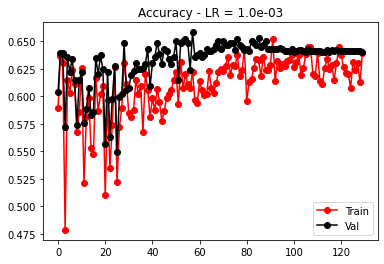

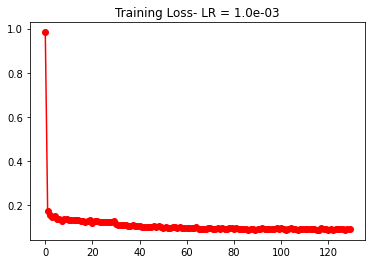

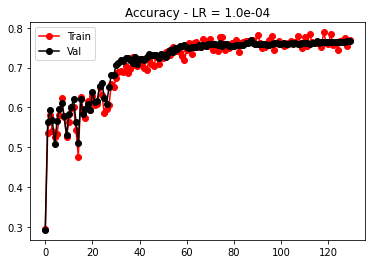

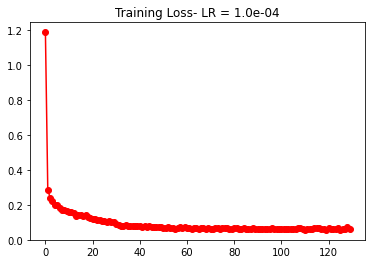

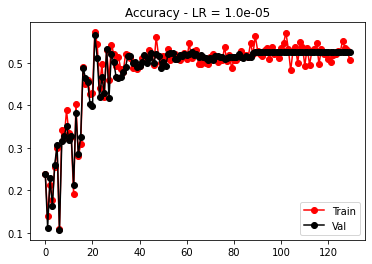

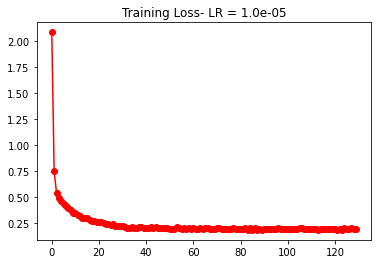

In [23]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-3,1e-4,1e-5] 
print("Number of Parameters:",count_number_parameters(model_24class_Res))
current_best_score = 0.5
for rate in learning_rates: 
    for layer in model_24class_Res.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_24class_Res.parameters(), lr=rate)
    n_epochs = 130

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy24(model_24class_Res,train_loader24_pre)
    start_acc_val = get_accuracy24(model_24class_Res,val_loader24_pre)
    accT = []
    accVal = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_24class_Res, train_loader24_pre, 
                                    val_loader24_pre)
        ## Evaluate the current model
        m_acc_train = get_accuracy24(model_24class_Res,train_loader24_pre)
        m_acc_val = get_accuracy24(model_24class_Res,val_loader24_pre)
        current_score = m_acc_val
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_24class_Res = copy.deepcopy(model_24class_Res)
            torch.save(best_model_24class_Res,'./best_model_project_24class_ResV2_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val))
        print("\nEpoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accVal.append(m_acc_val)
    plt.figure()
    plt.plot(accT,'ro-',accVal,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [59]:
# implementing the original 24class 5 layer model (without adaptive average pooling) with a spatial 
# transformer network to focus the network and decrease the variance due to rotation and scale
class SpatialTN_24class(torch.nn.Module):
    def __init__(self):
        super(SpatialTN_24class,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,16,5,1,2)
        self.conv2 = torch.nn.Conv2d(16,64,3,1,1)
        self.conv3 = torch.nn.Conv2d(64,128,3,1,1)
        self.fc1 = torch.nn.Linear(28*28*128,120)
        self.fc2 = torch.nn.Linear(120,24)
        
        #spatial transformer network
        self.STN = torch.nn.Sequential(
            torch.nn.Conv2d(1,8,7),
            torch.nn.MaxPool2d(2,stride=2),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8,10,5),
            torch.nn.MaxPool2d(2,stride=2),
            torch.nn.ReLU(True)
        )
        #affine matrix regressor
        self.fc_loc = torch.nn.Sequential(
            torch.nn.Linear(27040,32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32,3*2)
        )
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0], dtype=torch.float))
        
    def STN_forward(self,x):
        xs = self.STN(x)
        xs = xs.view(-1,xs.size(1)*xs.size(2)*xs.size(3))
        theta = self.fc_loc(xs)
        theta = theta.view(-1,2,3)
        x_size = x.size()
        grid = torch.nn.functional.affine_grid(theta,x.size())
        x = torch.nn.functional.grid_sample(x,grid)
        
        return x
    
    def forward(self,x):
        x = self.STN_forward(x)
        
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x),2))
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x),2))
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv3(x),2))
        x = x.view(-1,28*28*128)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x,training = self.training)
        x = self.fc2(x)
        return x
model_24class_STN = SpatialTN_24class().cuda()
print("Number of Parameters:",count_number_parameters(model_24class_STN))     

Number of Parameters: 12996736


Number of Parameters: 12996736


 Learning Rate =  0.001 



Initial accuracy - training and validation: 0.0 0.0 


Train Epoch: 0 	Loss: 0.21842
Train Acc: 0.63966 
Val Acc: 0.63913

Epoch time: 6.479272842407227 


Train Epoch: 1 	Loss: 0.14909
Train Acc: 0.63939 
Val Acc: 0.63859

Epoch time: 5.936654329299927 


Train Epoch: 2 	Loss: 0.14788
Train Acc: 0.63913 
Val Acc: 0.63939

Epoch time: 6.461465120315552 


Train Epoch: 3 	Loss: 0.14178
Train Acc: 0.63913 
Val Acc: 0.63939

Epoch time: 5.7238616943359375 


Train Epoch: 4 	Loss: 0.13841
Train Acc: 0.63886 
Val Acc: 0.63913

Epoch time: 5.644667625427246 


Train Epoch: 5 	Loss: 0.13872
Train Acc: 0.63886 
Val Acc: 0.63886

Epoch time: 5.645911693572998 


Train Epoch: 6 	Loss: 0.13599
Train Acc: 0.63886 
Val Acc: 0.63993

Epoch time: 6.171783924102783 


Train Epoch: 7 	Loss: 0.13492
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 5.852863311767578 


Train Epoch: 8 	Loss: 0.13672
Train Acc: 0.63886 
Val Acc: 0.63993

Epoch t

Train Epoch: 80 	Loss: 0.13037
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch time: 5.746124267578125 


Train Epoch: 81 	Loss: 0.13154
Train Acc: 0.63886 
Val Acc: 0.63939

Epoch time: 5.998754024505615 


Train Epoch: 82 	Loss: 0.12985
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 5.736375570297241 


Train Epoch: 83 	Loss: 0.12993
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.689232349395752 


Train Epoch: 84 	Loss: 0.13273
Train Acc: 0.63913 
Val Acc: 0.63886

Epoch time: 5.685160398483276 


Train Epoch: 85 	Loss: 0.13138
Train Acc: 0.63966 
Val Acc: 0.63939

Epoch time: 5.67612886428833 


Train Epoch: 86 	Loss: 0.13258
Train Acc: 0.63886 
Val Acc: 0.63913

Epoch time: 5.667007684707642 


Train Epoch: 87 	Loss: 0.13054
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.643751382827759 


Train Epoch: 88 	Loss: 0.13249
Train Acc: 0.63939 
Val Acc: 0.63859

Epoch time: 5.676960229873657 


Train Epoch: 89 	Loss: 0.13094
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.

Train Epoch: 35 	Loss: 0.14165
Train Acc: 0.63833 
Val Acc: 0.63939

Epoch time: 5.943982839584351 


Train Epoch: 36 	Loss: 0.14233
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 5.952508926391602 


Train Epoch: 37 	Loss: 0.14279
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.935370445251465 


Train Epoch: 38 	Loss: 0.14120
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.950491905212402 


Train Epoch: 39 	Loss: 0.14043
Train Acc: 0.63913 
Val Acc: 0.63886

Epoch time: 5.941213607788086 


Train Epoch: 40 	Loss: 0.14141
Train Acc: 0.63859 
Val Acc: 0.63993

Epoch time: 5.798224449157715 


Train Epoch: 41 	Loss: 0.14133
Train Acc: 0.63939 
Val Acc: 0.63886

Epoch time: 5.642008304595947 


Train Epoch: 42 	Loss: 0.13966
Train Acc: 0.63966 
Val Acc: 0.63939

Epoch time: 5.649243593215942 


Train Epoch: 43 	Loss: 0.14060
Train Acc: 0.63886 
Val Acc: 0.63939

Epoch time: 5.656149625778198 


Train Epoch: 44 	Loss: 0.14060
Train Acc: 0.63913 
Val Acc: 0.63939

Epoch time: 5

Train Epoch: 116 	Loss: 0.13789
Train Acc: 0.63913 
Val Acc: 0.63886

Epoch time: 5.655174016952515 


Train Epoch: 117 	Loss: 0.14038
Train Acc: 0.63859 
Val Acc: 0.63966

Epoch time: 5.668158292770386 


Train Epoch: 118 	Loss: 0.14038
Train Acc: 0.63913 
Val Acc: 0.63939

Epoch time: 5.64177942276001 


Train Epoch: 119 	Loss: 0.13851
Train Acc: 0.63966 
Val Acc: 0.63966

Epoch time: 5.662932634353638 


Train Epoch: 120 	Loss: 0.13946
Train Acc: 0.63939 
Val Acc: 0.63939

Epoch time: 5.666111707687378 


Train Epoch: 121 	Loss: 0.14322
Train Acc: 0.63966 
Val Acc: 0.63913

Epoch time: 5.727761745452881 


Train Epoch: 122 	Loss: 0.14147
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 5.96186375617981 


Train Epoch: 123 	Loss: 0.13902
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.951821327209473 


Train Epoch: 124 	Loss: 0.14300
Train Acc: 0.63966 
Val Acc: 0.63939

Epoch time: 5.942924976348877 




 Learning Rate =  1e-05 



Initial accuracy - training and validation: 0

Train Epoch: 71 	Loss: 0.18290
Train Acc: 0.63859 
Val Acc: 0.63966

Epoch time: 5.639756202697754 


Train Epoch: 72 	Loss: 0.18190
Train Acc: 0.63939 
Val Acc: 0.63886

Epoch time: 5.652292966842651 


Train Epoch: 73 	Loss: 0.17997
Train Acc: 0.63913 
Val Acc: 0.63859

Epoch time: 5.662320852279663 


Train Epoch: 74 	Loss: 0.18155
Train Acc: 0.63913 
Val Acc: 0.63913

Epoch time: 5.675435304641724 


Train Epoch: 75 	Loss: 0.18278
Train Acc: 0.63939 
Val Acc: 0.63886

Epoch time: 5.671466112136841 


Train Epoch: 76 	Loss: 0.18154
Train Acc: 0.63939 
Val Acc: 0.63966

Epoch time: 5.758919715881348 


Train Epoch: 77 	Loss: 0.18495
Train Acc: 0.63939 
Val Acc: 0.63913

Epoch time: 5.951391935348511 


Train Epoch: 78 	Loss: 0.18256
Train Acc: 0.63859 
Val Acc: 0.63886

Epoch time: 5.928249359130859 


Train Epoch: 79 	Loss: 0.18495
Train Acc: 0.63886 
Val Acc: 0.63913

Epoch time: 5.9428956508636475 


Train Epoch: 80 	Loss: 0.18913
Train Acc: 0.63886 
Val Acc: 0.63939

Epoch time: 

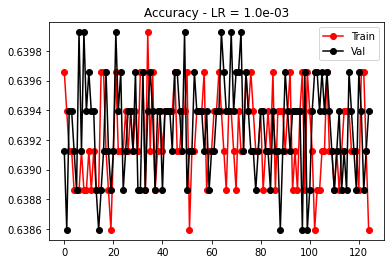

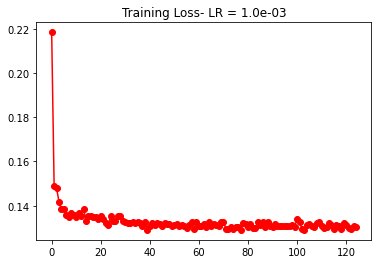

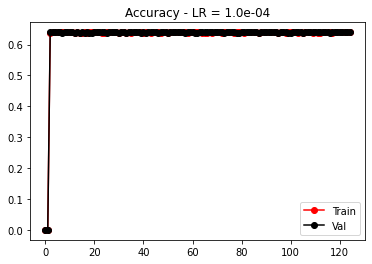

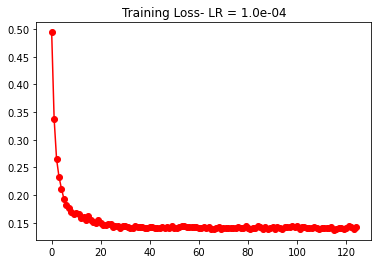

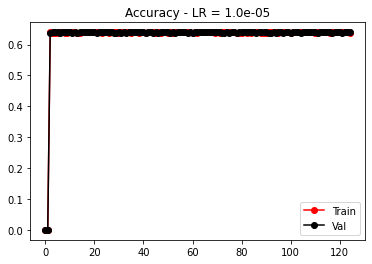

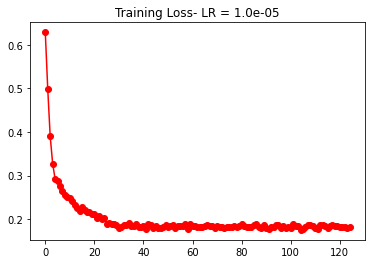

In [24]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-3,1e-4,1e-5] 
print("Number of Parameters:",count_number_parameters(model_24class_STN))
current_best_score = 0.5
for rate in learning_rates: 
    for layer in model_24class_STN.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_24class_STN.parameters(), lr=rate)
    n_epochs = 125

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy24(model_24class_STN,train_loader24_pre)
    start_acc_val = get_accuracy24(model_24class_STN,val_loader24_pre)
    accT = []
    accVal = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_24class_STN, train_loader24_pre, 
                                    val_loader24_pre)
        ## Evaluate the current model
        m_acc_train = get_accuracy24(model_24class_STN,train_loader24_pre)
        m_acc_val = get_accuracy24(model_24class_STN,val_loader24_pre)
        current_score = m_acc_val
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_24class_STN = copy.deepcopy(model_24class_STN)
            torch.save(best_model_24class_STN,'./best_model_project_24class_STN_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val))
        print("\nEpoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accVal.append(m_acc_val)
    plt.figure()
    plt.plot(accT,'ro-',accVal,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [56]:
os.chdir("/scratch/tmp/")

train_dataset = PneumoDataset3(chest_data_pre,split = 'none',do_transform = True)
val_dataset = PneumoDataset3_val(chest_data_pre_alt,split = 'val',do_transform = False)
test_dataset = PneumoDataset3_val(chest_xray_dataset, split = 'test',do_transform = False)

train_loader3 = torch.utils.data.DataLoader(train_dataset,batch_size = 8, shuffle = True, num_workers = 0)
val_loader3 = torch.utils.data.DataLoader(val_dataset,batch_size = 8, shuffle = True, num_workers = 0)
test_loader3 = torch.utils.data.DataLoader(test_dataset,batch_size = 8, shuffle = True, num_workers = 0)

In [29]:
model_3class = torch.nn.Sequential(
        torch.nn.ZeroPad2d(2),
        torch.nn.Conv2d(1,16,5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(16,64,3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(64,128,3),
        torch.nn.ReLU(),
        torch.nn.AdaptiveAvgPool2d(output_size = (3,3)),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = 1152, out_features = 256),
        torch.nn.Dropout(p=0.33),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 256, out_features = 3)
)
model_3class = model_3class.cuda()

Number of Parameters: 379491


 Learning Rate =  0.01 



Initial accuracy - training and validation: 0.037579957356076756 0.04044117647058824 0.04044117647058824 0.04044117647058824 


Train Epoch: 0 	Loss: 14.25289
Train Acc: 0.70682 
 Val1 Acc: 0.68505 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.68505

 epoch time: 3.5918948650360107 


Train Epoch: 1 	Loss: 0.37378
Train Acc: 0.70629 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.68811

 epoch time: 3.5843887329101562 


Train Epoch: 2 	Loss: 0.36435
Train Acc: 0.70656 
 Val1 Acc: 0.68505 	 Val2 Acc: 0.67892 
 Avg Val Acc: 0.68199

 epoch time: 3.9132182598114014 


Train Epoch: 3 	Loss: 0.37232
Train Acc: 0.70682 
 Val1 Acc: 0.67892 	 Val2 Acc: 0.69118 
 Avg Val Acc: 0.68505

 epoch time: 3.702584981918335 


Train Epoch: 4 	Loss: 0.37525
Train Acc: 0.70682 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.68811

 epoch time: 3.845243453979492 


Train Epoch: 5 	Loss: 0.36675
Train Acc: 0.70629 
 Val1 Acc: 0.68505 	 Val2

Train Epoch: 55 	Loss: 0.36272
Train Acc: 0.70576 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.67892 
 Avg Val Acc: 0.68505

 epoch time: 3.851797580718994 


Train Epoch: 56 	Loss: 0.36498
Train Acc: 0.70682 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.69118 
 Avg Val Acc: 0.69118

 epoch time: 3.5948596000671387 


Train Epoch: 57 	Loss: 0.36204
Train Acc: 0.70709 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.68811

 epoch time: 3.6122255325317383 


Train Epoch: 58 	Loss: 0.36387
Train Acc: 0.70629 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.67892 
 Avg Val Acc: 0.68505

 epoch time: 3.5908994674682617 


Train Epoch: 59 	Loss: 0.36294
Train Acc: 0.70602 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.68811

 epoch time: 3.8031563758850098 


Train Epoch: 60 	Loss: 0.36500
Train Acc: 0.70576 
 Val1 Acc: 0.68505 	 Val2 Acc: 0.67892 
 Avg Val Acc: 0.68199

 epoch time: 3.616071939468384 


Train Epoch: 61 	Loss: 0.36377
Train Acc: 0.70629 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.68505 
 Avg Val Acc: 0.6

Train Epoch: 10 	Loss: 0.34872
Train Acc: 0.70842 
 Val1 Acc: 0.69363 	 Val2 Acc: 0.69363 
 Avg Val Acc: 0.69363

 epoch time: 3.606720209121704 


Train Epoch: 11 	Loss: 0.35052
Train Acc: 0.71375 
 Val1 Acc: 0.70711 	 Val2 Acc: 0.70711 
 Avg Val Acc: 0.70711

 epoch time: 3.6224446296691895 


Train Epoch: 12 	Loss: 0.33691
Train Acc: 0.68923 
 Val1 Acc: 0.70343 	 Val2 Acc: 0.70343 
 Avg Val Acc: 0.70343

 epoch time: 3.587557315826416 


Train Epoch: 13 	Loss: 0.34466
Train Acc: 0.67644 
 Val1 Acc: 0.68260 	 Val2 Acc: 0.68873 
 Avg Val Acc: 0.68566

 epoch time: 3.5874526500701904 


Train Epoch: 14 	Loss: 0.33005
Train Acc: 0.70816 
 Val1 Acc: 0.69118 	 Val2 Acc: 0.69118 
 Avg Val Acc: 0.69118

 epoch time: 3.601280927658081 


Train Epoch: 15 	Loss: 0.37997
Train Acc: 0.70229 
 Val1 Acc: 0.68137 	 Val2 Acc: 0.68137 
 Avg Val Acc: 0.68137

 epoch time: 3.6073317527770996 


Train Epoch: 16 	Loss: 0.38305
Train Acc: 0.70149 
 Val1 Acc: 0.68505 	 Val2 Acc: 0.69118 
 Avg Val Acc: 0.68

Train Epoch: 66 	Loss: 0.25267
Train Acc: 0.75693 
 Val1 Acc: 0.77574 	 Val2 Acc: 0.76961 
 Avg Val Acc: 0.77267

 epoch time: 3.617617607116699 


Train Epoch: 67 	Loss: 0.23778
Train Acc: 0.75506 
 Val1 Acc: 0.75858 	 Val2 Acc: 0.76471 
 Avg Val Acc: 0.76164

 epoch time: 3.58237886428833 


Train Epoch: 68 	Loss: 0.25318
Train Acc: 0.76466 
 Val1 Acc: 0.76838 	 Val2 Acc: 0.76838 
 Avg Val Acc: 0.76838

 epoch time: 3.590824842453003 


Train Epoch: 69 	Loss: 0.24519
Train Acc: 0.76066 
 Val1 Acc: 0.77206 	 Val2 Acc: 0.76593 
 Avg Val Acc: 0.76900

 epoch time: 3.592647075653076 


Train Epoch: 70 	Loss: 0.23690
Train Acc: 0.75933 
 Val1 Acc: 0.77206 	 Val2 Acc: 0.77206 
 Avg Val Acc: 0.77206

 epoch time: 3.592665433883667 


Train Epoch: 71 	Loss: 0.25258
Train Acc: 0.75720 
 Val1 Acc: 0.75980 	 Val2 Acc: 0.77206 
 Avg Val Acc: 0.76593

 epoch time: 3.5938987731933594 


Train Epoch: 72 	Loss: 0.24354
Train Acc: 0.77559 
 Val1 Acc: 0.76961 	 Val2 Acc: 0.77574 
 Avg Val Acc: 0.77267

Train Epoch: 21 	Loss: 0.27440
Train Acc: 0.76279 
 Val1 Acc: 0.76961 	 Val2 Acc: 0.76961 
 Avg Val Acc: 0.76961

 epoch time: 3.591464042663574 


Train Epoch: 22 	Loss: 0.29821
Train Acc: 0.73428 
 Val1 Acc: 0.72426 	 Val2 Acc: 0.72426 
 Avg Val Acc: 0.72426

 epoch time: 3.6111748218536377 


Train Epoch: 23 	Loss: 0.29096
Train Acc: 0.74600 
 Val1 Acc: 0.73162 	 Val2 Acc: 0.72549 
 Avg Val Acc: 0.72855

 epoch time: 3.5719778537750244 


Train Epoch: 24 	Loss: 0.26937
Train Acc: 0.74947 
 Val1 Acc: 0.73284 	 Val2 Acc: 0.73284 
 Avg Val Acc: 0.73284

 epoch time: 3.873210906982422 


Train Epoch: 25 	Loss: 0.27407
Train Acc: 0.73987 
 Val1 Acc: 0.73284 	 Val2 Acc: 0.73284 
 Avg Val Acc: 0.73284

 epoch time: 3.900721788406372 


Train Epoch: 26 	Loss: 0.26024
Train Acc: 0.75666 
 Val1 Acc: 0.73039 	 Val2 Acc: 0.73652 
 Avg Val Acc: 0.73346

 epoch time: 3.8780791759490967 


Train Epoch: 27 	Loss: 0.27129
Train Acc: 0.76493 
 Val1 Acc: 0.77574 	 Val2 Acc: 0.76348 
 Avg Val Acc: 0.76

Train Epoch: 77 	Loss: 0.18903
Train Acc: 0.83209 
 Val1 Acc: 0.83824 	 Val2 Acc: 0.83824 
 Avg Val Acc: 0.83824

 epoch time: 3.8948118686676025 


Train Epoch: 78 	Loss: 0.19059
Train Acc: 0.83715 
 Val1 Acc: 0.83946 	 Val2 Acc: 0.84559 
 Avg Val Acc: 0.84252

 epoch time: 3.884049654006958 


Train Epoch: 79 	Loss: 0.18236
Train Acc: 0.83182 
 Val1 Acc: 0.84559 	 Val2 Acc: 0.83946 
 Avg Val Acc: 0.84252

 epoch time: 3.8811585903167725 


Train Epoch: 80 	Loss: 0.18293
Train Acc: 0.83555 
 Val1 Acc: 0.84314 	 Val2 Acc: 0.84314 
 Avg Val Acc: 0.84314

 epoch time: 3.897400379180908 


Train Epoch: 81 	Loss: 0.18881
Train Acc: 0.85261 
 Val1 Acc: 0.84926 	 Val2 Acc: 0.84926 
 Avg Val Acc: 0.84926

 epoch time: 3.9390830993652344 


Train Epoch: 82 	Loss: 0.18555
Train Acc: 0.83209 
 Val1 Acc: 0.83946 	 Val2 Acc: 0.84559 
 Avg Val Acc: 0.84252

 epoch time: 3.913428783416748 


Train Epoch: 83 	Loss: 0.19599
Train Acc: 0.83529 
 Val1 Acc: 0.84926 	 Val2 Acc: 0.84926 
 Avg Val Acc: 0.84

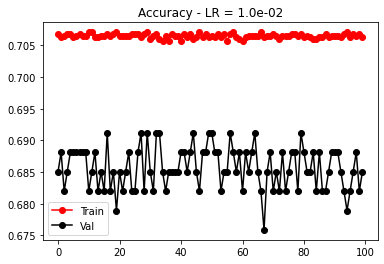

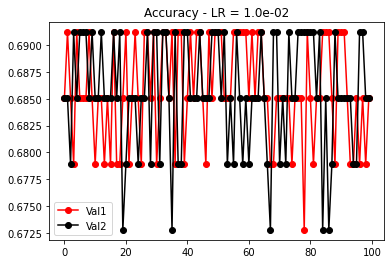

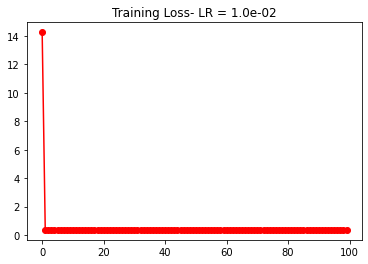

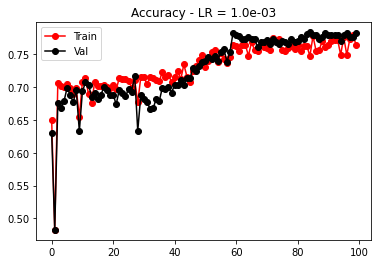

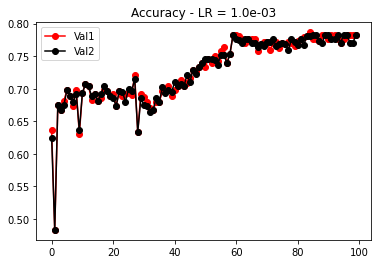

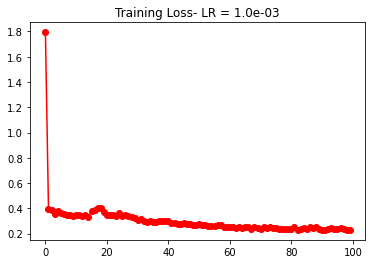

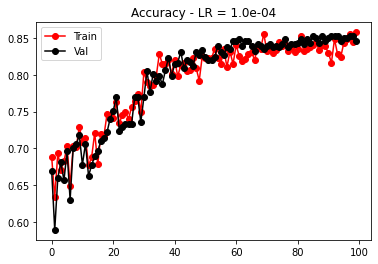

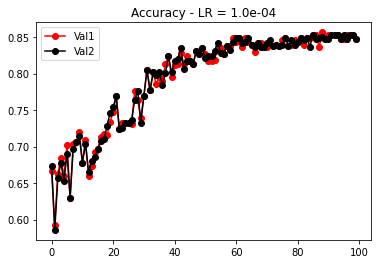

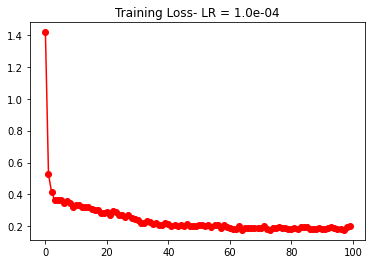

In [30]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-2,1e-3,1e-4] 
print("Number of Parameters:",count_number_parameters(model_3class))
current_best_score = 0.6
for rate in learning_rates:   
    for layer in model_3class.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_3class.parameters(), lr=rate)
    n_epochs = 100

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy3(model_3class,train_loader3)
    start_acc_val1 = get_accuracy3(model_3class,val_loader3)
    start_acc_val2 = get_accuracy3(model_3class,val_loader3)
    start_acc_val_avg = np.mean([start_acc_val1,start_acc_val2])
    accT = []
    acc1 = []
    acc2 = []
    accAVG = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val1,start_acc_val2,
          start_acc_val_avg,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_3class, train_loader3, val_loader3)
        ## Evaluate the current model
        m_acc_train = get_accuracy3(model_3class,train_loader3)
        m_acc_val1 = get_accuracy3(model_3class,val_loader3)
        m_acc_val2 = get_accuracy3(model_3class,val_loader3)
        m_acc_val_avg = np.mean([m_acc_val1,m_acc_val2])
        current_score = m_acc_val_avg
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_3class = copy.deepcopy(model_3class)
            torch.save(best_model_3class,'./best_model_project_3class_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \n Val1 Acc: {:.5f} \t Val2 Acc: {:.5f} \n Avg Val Acc: {:.5f}'.format(m_acc_train, m_acc_val1,m_acc_val2,m_acc_val_avg))
        print("\n epoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        acc1.append(m_acc_val1)
        acc2.append(m_acc_val2)
        accAVG.append(m_acc_val_avg)
    plt.figure()
    plt.plot(accT,'ro-',accAVG,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(acc1,'ro-',acc2,'ko-')
    plt.legend(['Val1','Val2'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [31]:
model_3class_noAAP = torch.nn.Sequential(
        torch.nn.ZeroPad2d(2),
        torch.nn.Conv2d(1,16,5,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(16,64,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Conv2d(64,128,3,1,1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride = 2),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = 128*28*28, out_features = 256),
        torch.nn.Dropout(p=0.33),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features = 256, out_features = 3)
)
model_3class_noAAP = model_3class_noAAP.cuda()

Number of Parameters: 25774691


 Learning Rate =  0.001 



Initial accuracy - training and validation: 0.020522388059701493 0.014705882352941176 


Train Epoch: 0 	Loss: 30.43540
Train Acc: 0.57383 
Val Acc: 0.60723

 epoch time: 5.9961278438568115 


Train Epoch: 1 	Loss: 0.47970
Train Acc: 0.63193 
Val Acc: 0.60784

 epoch time: 6.180217504501343 


Train Epoch: 2 	Loss: 0.42802
Train Acc: 0.67671 
Val Acc: 0.68199

 epoch time: 6.071492433547974 


Train Epoch: 3 	Loss: 0.41351
Train Acc: 0.68257 
Val Acc: 0.64461

 epoch time: 4.965017795562744 


Train Epoch: 4 	Loss: 0.41156
Train Acc: 0.69510 
Val Acc: 0.67463

 epoch time: 4.96791934967041 


Train Epoch: 5 	Loss: 0.40650
Train Acc: 0.70709 
Val Acc: 0.67218

 epoch time: 4.976936340332031 


Train Epoch: 6 	Loss: 0.41370
Train Acc: 0.71215 
Val Acc: 0.68382

 epoch time: 6.062569856643677 


Train Epoch: 7 	Loss: 0.39665
Train Acc: 0.70842 
Val Acc: 0.68566

 epoch time: 6.091475486755371 


Train Epoch: 8 	Loss: 0.39483
Tra

Train Epoch: 79 	Loss: 0.35828
Train Acc: 0.70602 
Val Acc: 0.68199

 epoch time: 4.971475601196289 


Train Epoch: 80 	Loss: 0.36234
Train Acc: 0.70656 
Val Acc: 0.68199

 epoch time: 4.990729093551636 


Train Epoch: 81 	Loss: 0.36143
Train Acc: 0.70576 
Val Acc: 0.68199

 epoch time: 5.025650978088379 


Train Epoch: 82 	Loss: 0.35861
Train Acc: 0.70682 
Val Acc: 0.68505

 epoch time: 4.954182863235474 


Train Epoch: 83 	Loss: 0.35964
Train Acc: 0.70629 
Val Acc: 0.69118

 epoch time: 4.978126049041748 


Train Epoch: 84 	Loss: 0.36163
Train Acc: 0.70682 
Val Acc: 0.68811

 epoch time: 4.966219902038574 


Train Epoch: 85 	Loss: 0.36448
Train Acc: 0.70656 
Val Acc: 0.68811

 epoch time: 4.942139387130737 


Train Epoch: 86 	Loss: 0.36004
Train Acc: 0.70656 
Val Acc: 0.68811

 epoch time: 4.978365182876587 


Train Epoch: 87 	Loss: 0.35930
Train Acc: 0.70682 
Val Acc: 0.68505

 epoch time: 5.084962844848633 


Train Epoch: 88 	Loss: 0.35773
Train Acc: 0.70629 
Val Acc: 0.69118

 epo

Train Epoch: 58 	Loss: 0.10821
Train Acc: 0.92351 
Val Acc: 0.95221

 epoch time: 5.2849390506744385 


Train Epoch: 59 	Loss: 0.11698
Train Acc: 0.93097 
Val Acc: 0.96324

 epoch time: 5.302401542663574 


Train Epoch: 60 	Loss: 0.10219
Train Acc: 0.92324 
Val Acc: 0.95588

 epoch time: 5.300696134567261 


Train Epoch: 61 	Loss: 0.11513
Train Acc: 0.93257 
Val Acc: 0.95282

 epoch time: 5.3102617263793945 


Train Epoch: 62 	Loss: 0.10044
Train Acc: 0.92697 
Val Acc: 0.94914

 epoch time: 5.298033237457275 


Train Epoch: 63 	Loss: 0.09513
Train Acc: 0.92724 
Val Acc: 0.94240

 epoch time: 5.294170379638672 


Train Epoch: 64 	Loss: 0.11293
Train Acc: 0.91791 
Val Acc: 0.95221

 epoch time: 5.293065309524536 


Train Epoch: 65 	Loss: 0.09585
Train Acc: 0.92910 
Val Acc: 0.94914

 epoch time: 5.287975788116455 


Train Epoch: 66 	Loss: 0.11152
Train Acc: 0.92351 
Val Acc: 0.95221

 epoch time: 5.299001693725586 


Train Epoch: 67 	Loss: 0.11326
Train Acc: 0.92164 
Val Acc: 0.95221

 e

Train Epoch: 37 	Loss: 0.33561
Train Acc: 0.73827 
Val Acc: 0.76103

 epoch time: 5.124186038970947 


Train Epoch: 38 	Loss: 0.33843
Train Acc: 0.74574 
Val Acc: 0.75797

 epoch time: 5.25281548500061 


Train Epoch: 39 	Loss: 0.33442
Train Acc: 0.75293 
Val Acc: 0.74020

 epoch time: 5.246338129043579 


Train Epoch: 40 	Loss: 0.32189
Train Acc: 0.75906 
Val Acc: 0.76532

 epoch time: 5.257587432861328 


Train Epoch: 41 	Loss: 0.32788
Train Acc: 0.74014 
Val Acc: 0.74326

 epoch time: 5.251108884811401 


Train Epoch: 42 	Loss: 0.33581
Train Acc: 0.75480 
Val Acc: 0.75123

 epoch time: 5.149847030639648 


Train Epoch: 43 	Loss: 0.32447
Train Acc: 0.74920 
Val Acc: 0.76838

 epoch time: 4.976420640945435 


Train Epoch: 44 	Loss: 0.32278
Train Acc: 0.74200 
Val Acc: 0.73223

 epoch time: 4.979979991912842 


Train Epoch: 45 	Loss: 0.34386
Train Acc: 0.76839 
Val Acc: 0.74387

 epoch time: 4.973424673080444 


Train Epoch: 46 	Loss: 0.33055
Train Acc: 0.73801 
Val Acc: 0.76471

 epoc

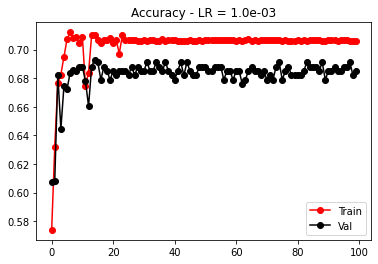

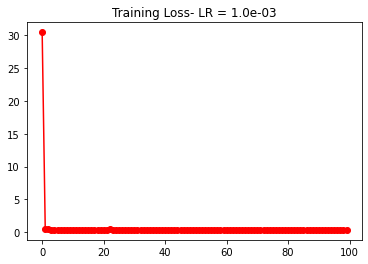

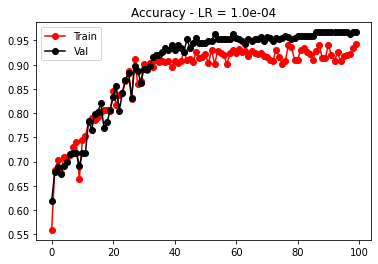

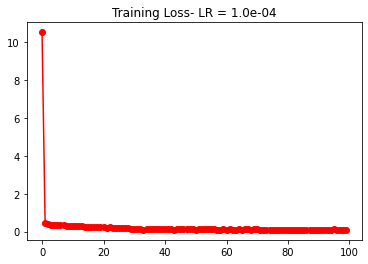

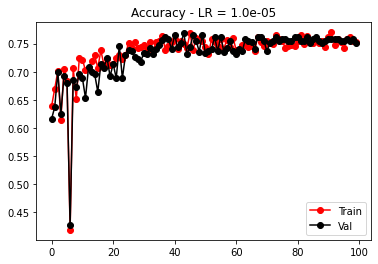

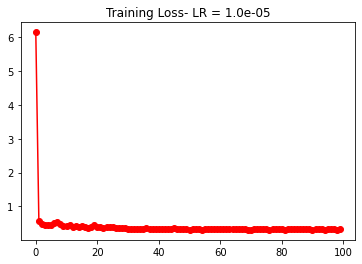

In [32]:
os.chdir("/scratch/tmp/u1063288")
learning_rates = [1e-3,1e-4,1e-5] 
print("Number of Parameters:",count_number_parameters(model_3class_noAAP))
current_best_score = 0.6
for rate in learning_rates:
    for layer in model_3class_noAAP.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    print("\n\n Learning Rate = ",rate,"\n\n")
    optimizer = torch.optim.Adam(model_3class_noAAP.parameters(), lr=rate)
    n_epochs = 100

    ## Using the scheduler module to reduce the learning rate after reaching a plateau. 
    ## More information about the scheduler can be found at 
    ## https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    start_acc_train = get_accuracy3(model_3class_noAAP,train_loader3)
    start_acc_val_avg = get_accuracy3(model_3class_noAAP,val_loader3)
    accT = []
    accAVG = []
    tLoss = []
    print("\nInitial accuracy - training and validation:",start_acc_train,start_acc_val_avg,"\n\n")

    for epoch in range(n_epochs):
        start_ep = time.time()
        ## Train the model
        loss_value = training_stage(epoch, optimizer, MLoss, model_3class_noAAP, train_loader3, val_loader3)
        ## Evaluate the current model
        m_acc_train = get_accuracy3(model_3class_noAAP,train_loader3)
        m_acc_val1 = get_accuracy3(model_3class_noAAP,val_loader3)
        m_acc_val2 = get_accuracy3(model_3class_noAAP,val_loader3)
        m_acc_val_avg = np.mean([m_acc_val1,m_acc_val2])
        current_score = m_acc_val_avg
        ## Save the model
        if current_score > current_best_score:
            current_best_score = current_score
            best_model_3class_noAAP = copy.deepcopy(model_3class_noAAP)
            torch.save(best_model_3class_noAAP,'./best_model_project_3class_noAAP_Final.pt')
        ep_time = time.time()-start_ep
        print('Train Epoch: {:d} \tLoss: {:.5f}'.format(epoch,loss_value))
        print('Train Acc: {:.5f} \nVal Acc: {:.5f}'.format(m_acc_train,m_acc_val_avg))
        print("\n epoch time:",ep_time,"\n\n")
        ## Activate scheduler
        scheduler.step()
        tLoss.append(loss_value)
        accT.append(m_acc_train)
        accAVG.append(m_acc_val_avg)
    plt.figure()
    plt.plot(accT,'ro-',accAVG,'ko-')
    plt.legend(['Train','Val'])
    plt.title('Accuracy - LR = {:.1e}'.format(rate))

    plt.figure()
    plt.plot(tLoss,'ro-')
    plt.title('Training Loss- LR = {:.1e}'.format(rate))

In [57]:
os.chdir("/scratch/tmp/u1063288")
best_model_3aapGV = torch.load('./best_model_project_3class_noAAP_Final.pt')
best_model_3GV = torch.load('./best_model_project_3class_Final.pt')
best_model_3aapBV = torch.load('./best_model_project_3class_noAAPV2.pt')
best_model_3BV = torch.load('./best_model_project_3classV2.pt')

test_3aapGV = get_accuracy3(best_model_3aapGV,test_loader3)
test_3aapBV = get_accuracy3(best_model_3aapBV,test_loader3)
test_3GV = get_accuracy3(best_model_3GV,test_loader3)
test_3BV = get_accuracy3(best_model_3BV,test_loader3)

print("Test 3 No AAP good validation:",test_3aapGV,"\nTest 3 No AAP bad validation:",test_3aapBV,
     "\nTest 3 with AAP good validation:",test_3GV,"\nTest 3 with AAP bad validation:",test_3BV,)

Test 3 No AAP good validation: 0.9742647058823529 
Test 3 No AAP bad validation: 0.7977941176470589 
Test 3 with AAP good validation: 0.8639705882352942 
Test 3 with AAP bad validation: 0.875


In [65]:
best_model_247GV = torch.load('./best_model_project_24class_ext_Final.pt')
best_model_24GV = torch.load('./best_model_project_24class_Final.pt')
best_model_247BV = torch.load('./best_model_project_24class_extV2.pt')
best_model_24BV = torch.load('./best_model_project_24classV2.pt')
best_model_24ResV2 = torch.load('./best_model_project_24class_ResV2_Final.pt')
best_model_24DNI = torch.load('./best_model_project_24classDNI_Final.pt')
best_model_24STN = torch.load('./best_model_project_24class_STN_Final.pt')

test_247GV = get_accuracy24(best_model_247GV,test_loader24)
test_247BV = get_accuracy24(best_model_247BV,test_loader24)
test_24GV = get_accuracy24(best_model_24GV,test_loader24)
test_24BV = get_accuracy24(best_model_24BV,test_loader24)
test_Res2 = get_accuracy24(best_model_24ResV2,test_loader24)
test_DNI = get_accuracy24(best_model_24DNI,test_loader24)
test_STN = get_accuracy24(best_model_24STN,test_loader24)

print("Test 24 7-layer good validation:",test_247GV,"\nTest 24 7-layer bad validation:",test_247BV,
     "\nTest 24 with AAP good validation:",test_24GV,"\nTest 24 with AAP bad validation:",test_24BV,
     "\nTest 24 3 res:",test_Res2,"\nTest 24 DarkNet:",test_DNI,"\nTest 24 Spatial transformer:",test_STN)

Test 24 7-layer good validation: 0.9117803837953092 
Test 24 7-layer bad validation: 0.9363006396588486 
Test 24 with AAP good validation: 0.8619402985074627 
Test 24 with AAP bad validation: 0.6769722814498933 
Test 24 3 res: 0.75 
Test 24 DarkNet: 0.09541577825159915 
Test 24 Spatial transformer: 0.6391257995735607


In [33]:
frequencies_train = np.sum(train_dataset.target_list, axis = 0)
text_frequencies_train = ['{:.2f}'.format(frequency) for frequency in frequencies_train]                    

frequencies_val = np.sum(val_dataset.target_list, axis = 0)
text_frequencies_val = ['{:.2f}'.format(frequency) for frequency in frequencies_val] 

frequencies_test = np.sum(test_dataset.target_list, axis = 0)
text_frequencies_test = ['{:.2f}'.format(frequency) for frequency in frequencies_val] 

print_freq_train = pd.Series(dict(zip(chest_xray_dataset.pathologies,text_frequencies_train)))
print_freq_val = pd.Series(dict(zip(chest_xray_dataset.pathologies,text_frequencies_val)))
print_freq_test = pd.Series(dict(zip(chest_xray_dataset.pathologies,text_frequencies_test)))
print("Training label frquency\n",print_freq_train)
print("\n\n Validation Label freq\n",print_freq_val)
print("\n\n Old Validation Label Freq\n",print_freq_test)

Training label frquency
 Aspergillosis     48.00
Aspiration        23.00
Bacterial        378.00
dtype: object


 Validation Label freq
 Aspergillosis     22.00
Aspiration        11.00
Bacterial        183.00
dtype: object


 Old Validation Label Freq
 Aspergillosis     22.00
Aspiration        11.00
Bacterial        183.00
dtype: object
